In [1]:
import cv2 as cv

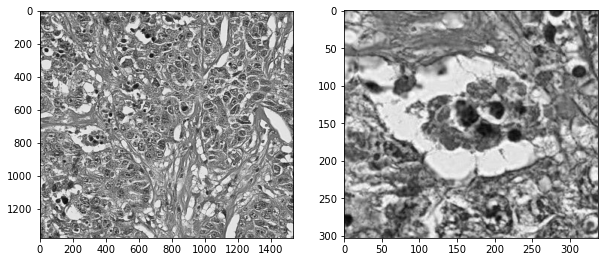

In [15]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

img1 = cv.imread("A03_00Cb.jpg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("A03_00Cb_cr.jpg", cv.IMREAD_GRAYSCALE)


if img1 is None or img2 is None:
    print('Could not open or find the images!')
    exit(0)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

In [16]:
detector = cv.ORB_create(10000)
kpts1 = detector.detect(img1, None)
kpts2 = detector.detect(img2, None)

In [17]:
# descriptor = cv.ORB_create()
descriptor = cv.xfeatures2d.BEBLID_create(0.75)
kpts1, desc1 = descriptor.compute(img1, kpts1)
kpts2, desc2 = descriptor.compute(img2, kpts2)

In [18]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8  # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(m)
        matched2.append(m)

In [19]:
matched1

[<DMatch 000002616DF113D0>,
 <DMatch 000002616DF130D0>,
 <DMatch 000002616DF168F0>,
 <DMatch 000002616DF187B0>,
 <DMatch 000002616DF18BD0>,
 <DMatch 000002616DF18DD0>,
 <DMatch 000002616DF1AC10>,
 <DMatch 000002616DF1C8D0>,
 <DMatch 000002616DF251D0>,
 <DMatch 000002616DF25E50>,
 <DMatch 000002616DF27850>,
 <DMatch 000002616DF279D0>,
 <DMatch 000002616DF2A170>,
 <DMatch 000002616DF2A5B0>,
 <DMatch 000002616DF2A5F0>,
 <DMatch 000002616DF2C5F0>,
 <DMatch 000002616DF301F0>,
 <DMatch 000002616DF302B0>,
 <DMatch 000002616DF30590>,
 <DMatch 000002616DF30AB0>,
 <DMatch 000002616DF30B70>,
 <DMatch 000002616DF33210>,
 <DMatch 000002616DF33450>,
 <DMatch 000002616DF335D0>,
 <DMatch 000002616DF33CB0>,
 <DMatch 000002616DF35150>,
 <DMatch 000002616DF352D0>,
 <DMatch 000002616DF35EB0>,
 <DMatch 000002616DF37430>,
 <DMatch 000002616DF376B0>,
 <DMatch 000002616DF376F0>,
 <DMatch 000002616DF37F10>,
 <DMatch 000002616DF39990>,
 <DMatch 000002616DF3C310>,
 <DMatch 000002616DF3C750>,
 <DMatch 000002616DF

In [20]:
MIN_MATCH_COUNT = 10

In [21]:
if len(matched1)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kpts1[m.queryIdx].pt for m in matched1 ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpts2[m.trainIdx].pt for m in matched2 ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)

In [22]:
M

array([[ 1.00616365e+00,  1.81983829e-03, -1.47258480e+02],
       [ 7.79409487e-04,  1.00815756e+00, -6.38772629e+02],
       [-2.20189821e-06,  9.43178404e-06,  1.00000000e+00]])

In [23]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8  # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])

In [24]:
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5  # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    # Create the homogeneous point
    col = np.ones((3, 1), dtype=np.float64)
    col[0:2, 0] = m.pt
    # Project from image 1 to image 2
    col = np.dot(M, col)
    col /= col[2, 0]
    # Calculate euclidean distance
    dist = sqrt(pow(col[0, 0] - matched2[i].pt[0], 2) + \
                pow(col[1, 0] - matched2[i].pt[1], 2))
    if dist < inlier_threshold:
        good_matches.append(cv.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])

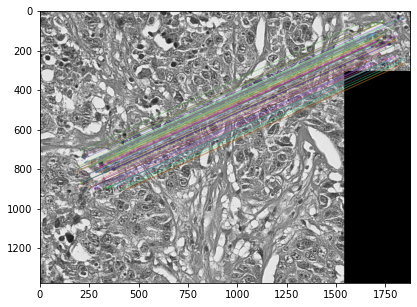

In [25]:
res = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, inliers1, img2, inliers2, good_matches, res)
plt.figure(figsize=(15, 5))
plt.imshow(res)

In [26]:
inlier_ratio = len(inliers1) / float(len(matched1))
print('Matching Results')
print('*******************************')
print('# Keypoints 1:                        \t', len(kpts1))
print('# Keypoints 2:                        \t', len(kpts2))
print('# Matches:                            \t', len(matched1))
print('# Inliers:                            \t', len(inliers1))
print('# Inliers Ratio:                      \t', inlier_ratio)

Matching Results
*******************************
# Keypoints 1:                        	 10000
# Keypoints 2:                        	 5563
# Matches:                            	 240
# Inliers:                            	 216
# Inliers Ratio:                      	 0.9
